In [14]:
import openai
import os
import pandas as pd
import tweepy
import openai
import re
from tqdm import tqdm
import seaborn as sns


# Function for getting data given a ticker
def getData(ticker):
    tweet_dataset = []
    tweets = twitterAPI.search_tweets(q=ticker + ' -filter:retweets -filter:replies',
                                      lang="en",
                                      result_type="recent",
                                      count=100
                                      )
    for tweet in tweets:
        tweet_content = {'id': tweet.id,
                         'date': tweet.created_at,
                         'user_name': tweet.user.screen_name,
                         'text': tweet.text,
                         }

        tweet_dataset.append(tweet_content)

    tweet_dataframe = pd.DataFrame(tweet_dataset)
    return tweet_dataframe


#Function for getting sentiment of tweet
def get_sentiment(text,ticker):
    prompt_text = """Classify the sentiment of the following tweet as positive, negative, or neutral towards {}.
    text: {}
    sentiment: """.format(ticker,text)

    sentiment = openai.Completion.create(
        model="gpt-3.5-turbo",
        prompt=prompt_text,
        max_tokens=15,
        temperature=0,
    )

    # remove special characters e.g n etc, from response
    sentiment = re.sub('W+', '', sentiment['choices'][0]['text'])

    return sentiment


# Put in your tokens
consumer_key = "BkEPb0jyEMmw878gj74vOrkFY"
consumer_secret = "24dZiQhAZdTX4QFuZc9EZpfYJdnw83tzTARVq9KH0mITjQrcyE"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAL4NnAEAAAAAp%2BpBIxt%2FjZja7nn5wEZtInIgCAs%3DFzdsKA1nkcN6OrdDlCGiuKHcpRDowA8lcNAmZT0FVwl5YefguE"
openai.api_key = 'pk-JsMTVtPJVasDqBDFMosXZqmbfTRPYxhWbvCWRqzhkTDGGpUe'
openai.api_base = 'https://api.pawan.krd/v1'

# Connect to the Twitter API
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
twitterAPI = tweepy.API(auth)

100%|██████████| 95/95 [01:57<00:00,  1.23s/it]

 Neutral     62
 Positive    29
 Negative     4
Name: sentiment, dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='count'>

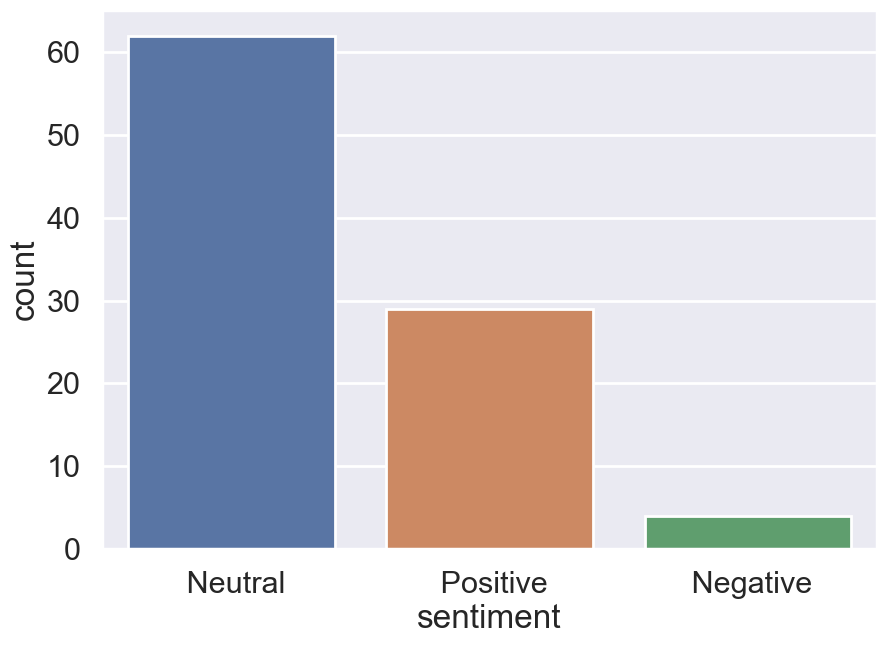

In [15]:
# Supply the key word and get your pandas dataframe
keyWord = "Bitcoin"
tweet_df = getData(keyWord)

tqdm.pandas()

tweet_df['sentiment'] = tweet_df['text'].progress_apply(lambda x: get_sentiment(x, keyWord))
tweet_df.head()

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize': (10, 7)})
sns.set_context("poster")

print(tweet_df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=tweet_df)